# IKZF1
[common variable immunodeficiency-13 (CVID13)](https://omim.org/entry/616873) is caused by heterozygous mutation in the IKZF1 gene. CVID13 is an autosomal dominant primary immunodeficiency disorder characterized by recurrent bacterial infections, mainly affecting the respiratory tract, and associated with hypogammaglobulinemia and decreased numbers of B cells. The age at onset of clinical features can range from infancy to adulthood.
Many published IKZF1 vairants are thought to be loss of function ([PMID: 31057532](https://pubmed.ncbi.nlm.nih.gov/31057532/)). Heterozygous mutations affecting amino acid N159 located in the DNA-binding domain of IKZF1 are thought to act in a dominant-negative fashion and were reported to be associated with early-onset and severe manifestations often including
Pneumocystis jirovecii pneumonia ([PMID:](29889099)https://pubmed.ncbi.nlm.nih.gov/29889099/).
Here, we test a cohort of individuals with pathogenic IKZF1 variants.

Germline variants in IKZF1 encoding for the lymphoid transcription factor IKAROS, are associated with inborn errors of immunity characterized by immune dysregulation, autoimmunity and an increased risk for malignancy. IKAROS is important in hematopoietic development, but also required for the development of autoimmune regulator-positive (AIRE+) mTEC (Sin et al. 2023).  Knowledge of the genotype-phenotype correlations such as the ones described above has the great potential to improve patient management.

In [15]:
import gpsea
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.1


### IKZF
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for IKZF.

In [16]:
gene_symbol = 'IKZF1'
mane_tx_id = 'NM_006060.6'
mane_protein_id = 'NP_006051.1' # DNA-binding protein Ikaros isoform 1

In [17]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 82 phenopackets
Individuals Processed: 100%|██████████| 82/82 [00:20<00:00,  4.07individuals/s]
Validated under permissive policy
No errors or warnings were found


In [18]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
61,B lymphocytopenia
50,Decreased circulating IgA concentration
49,Decreased circulating total IgM
46,Decreased circulating IgG concentration
29,Decreased CD4:CD8 ratio
22,Decreased proportion of memory B cells
17,Recurrent infections
16,Decreased proportion of CD4-positive T cells
14,Recurrent pneumonia
14,Pneumocystis jirovecii pneumonia


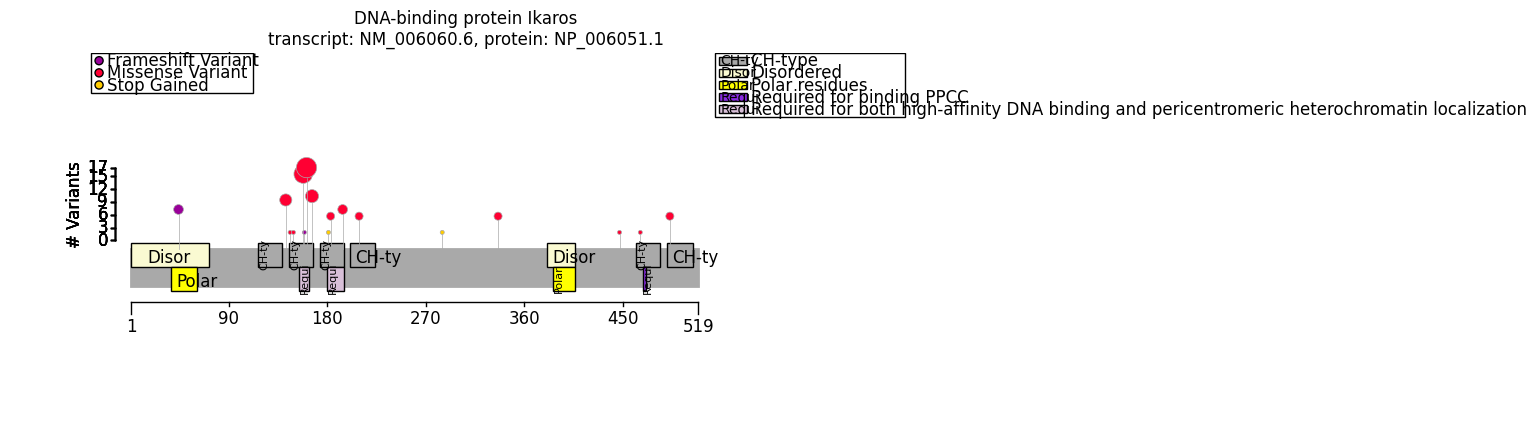

In [19]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


IKZF1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
IKZF1_fig.tight_layout()

In [20]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
3,Disordered,Region,2 - 72,p.Ser46AlafsTer14
3,Polar residues,Compositional bias,38 - 61,p.Ser46AlafsTer14
0,C2H2-type 1,Zinc finger,118 - 139,
40,C2H2-type 2,Zinc finger,146 - 167,p.Arg162Leu; p.Asn159Thr; p.Asn159Ser; p.Cys147Arg; p.Arg162Trp; p.Arg162Gln; p.His163SerfsTer32; p.Cys150Arg; p.His167Arg; p.His167Tyr
32,Required for both high-affinity DNA binding and pericentromeric heterochromatin localization,Region,155 - 163,p.Arg162Leu; p.Asn159Thr; p.Asn159Ser; p.Arg162Trp; p.Arg162Gln; p.His163SerfsTer32
6,C2H2-type 3,Zinc finger,174 - 195,p.Cys182Ter; p.Arg184Gln; p.His195Arg
6,Required for both high-affinity DNA binding and pericentromeric heterochromatin localization,Region,181 - 195,p.Cys182Ter; p.Arg184Gln; p.His195Arg
2,C2H2-type 4,Zinc finger,202 - 224,p.Tyr210Cys
0,Disordered,Region,382 - 406,
0,Polar residues,Compositional bias,387 - 406,


# Genotype-Phenotype Correlation (GPC) Analysis

In [21]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [22]:
from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

asn159ser = variant_key("7_50382594_50382594_A_G") # p.Asn159Ser	
asn159ser_clf = monoallelic_classifier(
    a_predicate=asn159ser,
    b_predicate= ~asn159ser,
    a_label='p.Asn159Ser',
    b_label='Other variant'
)

asn159ser_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=asn159ser_clf,
    pheno_clfs=pheno_clfs,
)
viewer = MtcStatsViewer()
viewer.process(asn159ser_result)


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,22
HMF03,Skipping term because of a child term with the same individual counts,3
HMF05,Skipping term because one genotype had zero observations,1
HMF08,Skipping general term,59
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,106


In [23]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, asn159ser_result)

Allele group                                       p.Asn159Ser          \
                                                         Count Percent   
Recurrent pneumonia [HP:0006532]                           7/9     78%   
Recurrent otitis media [HP:0000403]                        3/6     50%   
Decreased circulating total IgM [HP:0002850]               9/9    100%   
Recurrent sinusitis [HP:0011108]                           1/1    100%   
Decreased CD4:CD8 ratio [HP:0033222]                       1/7     14%   
Chronic diarrhea [HP:0002028]                              1/1    100%   
Decreased circulating IgG concentration [HP:000...         8/8    100%   
Decreased circulating IgA concentration [HP:000...         9/9    100%   
B lymphocytopenia [HP:0010976]                           13/13    100%   
Increased proportion of CD4-positive T cells [H...        4/10     40%   
Recurrent respiratory infections [HP:0002205]              9/9    100%   
Recurrent infections [HP:0002719]                        11/11    100%   
Unusual infection [HP:0032101]                           13/13    100%   
Abnormal T cell subset distribution [HP:0025540]           8/8    100%   
Abnormal T cell count [HP:0011839]                         8/8    100%   
Abnormal lymphocyte count [HP:0040088]                   13/13    100%   
Abnormal B cell count [HP:0010975]                       13/13    100%   
Lymphopenia [HP:0001888]                                 13/13    100%   
Abnormal B cell subset distribution [HP:0025539]           2/2    100%   
Decreased proportion of CD4-positive T cells [H...        4/10     40%   
Abnormal circulating IgG concentration [HP:0410...         8/8    100%   
Abnormal circulating immunoglobulin concentrati...       13/13    100%   
Decreased circulating antibody concentration [H...       13/13    100%   
Abnormal circulating IgA concentration [HP:0410...         9/9    100%   
Abnormal circulating IgM concentration [HP:0410...         9/9    100%   

Allele group                                       Other variant          \
                                                           Count Percent   
Recurrent pneumonia [HP:0006532]                            7/39     18%   
Recurrent otitis media [HP:0000403]                         7/48     15%   
Decreased circulating total IgM [HP:0002850]               40/56     71%   
Recurrent sinusitis [HP:0011108]                            5/50     10%   
Decreased CD4:CD8 ratio [HP:0033222]                       28/59     47%   
Chronic diarrhea [HP:0002028]                               6/49     12%   
Decreased circulating IgG concentration [HP:000...         38/51     75%   
Decreased circulating IgA concentration [HP:000...         41/54     76%   
B lymphocytopenia [HP:0010976]                             48/58     83%   
Increased proportion of CD4-positive T cells [H...          6/28     21%   
Recurrent respiratory infections [HP:0002205]              23/25     92%   
Recurrent infections [HP:0002719]                          41/41    100%   
Unusual infection [HP:0032101]                             42/42    100%   
Abnormal T cell subset distribution [HP:0025540]           34/34    100%   
Abnormal T cell count [HP:0011839]                         35/35    100%   
Abnormal lymphocyte count [HP:0040088]                     60/60    100%   
Abnormal B cell count [HP:0010975]                         57/57    100%   
Lymphopenia [HP:0001888]                                   48/48    100%   
Abnormal B cell subset distribution [HP:0025539]           33/33    100%   
Decreased proportion of CD4-positive T cells [H...         12/33     36%   
Abnormal circulating IgG concentration [HP:0410...         38/38    100%   
Abnormal circulating immunoglobulin concentrati...         56/56    100%   
Decreased circulating antibody concentration [H...         56/56    100%   
Abnormal circulating IgA concentration [HP:0410...         41/41    100%   
Abnormal circulating IgM 

In [29]:
from gpsea.analysis.predicate import variant_effect
from gpsea.model import VariantEffect

missense = variant_effect(VariantEffect.MISSENSE_VARIANT,  mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="oher"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, missense_result)

Allele group                                       Missense           oher  \
                                                      Count Percent  Count   
Recurrent pneumonia [HP:0006532]                      13/31     42%   1/17   
Decreased CD4:CD8 ratio [HP:0033222]                  22/43     51%   7/23   
B lymphocytopenia [HP:0010976]                        46/51     90%  15/20   
Decreased circulating IgG concentration [HP:000...    34/41     83%  12/18   
Recurrent respiratory infections [HP:0002205]         25/26     96%    7/8   
Decreased proportion of CD4-positive T cells [H...    12/29     41%   4/14   
Decreased proportion of memory B cells [HP:0030...    17/18     94%  15/17   
Recurrent infections [HP:0002719]                     39/39    100%  13/13   
Unusual infection [HP:0032101]                        42/42    100%  13/13   
Abnormal T cell subset distribution [HP:0025540]      32/32    100%  10/10   
Abnormal T cell count [HP:0011839]                    32/32    100%  11/11   
Abnormal lymphocyte count [HP:0040088]                52/52    100%  21/21   
Abnormal B cell count [HP:0010975]                    49/49    100%  21/21   
Lymphopenia [HP:0001888]                              46/46    100%  15/15   
Abnormal B cell subset distribution [HP:0025539]      19/19    100%  16/16   
Abnormal circulating IgG concentration [HP:0410...    34/34    100%  12/12   
Abnormal circulating immunoglobulin concentrati...    49/49    100%  20/20   
Decreased circulating antibody concentration [H...    49/49    100%  20/20   
Decreased circulating IgA concentration [HP:000...    34/43     79%  16/20   
Abnormal circulating IgA concentration [HP:0410...    34/34    100%  16/16   
Decreased circulating total IgM [HP:0002850]          34/45     76%  15/20   
Abnormal circulating IgM concentration [HP:0410...    34/34    100%  15/15   

Allele group                                                                   \
                                                   Percent Corrected p values   
Recurrent pneumonia [HP:0006532]                        6%           0.202612   
Decreased CD4:CD8 ratio [HP:0033222]                   30%           0.963521   
B lymphocytopenia [HP:0010976]                         75%           0.963521   
Decreased circulating IgG concentration [HP:000...     67%           1.000000   
Recurrent respiratory infections [HP:0002205]          88%           1.000000   
Decreased proportion of CD4-positive T cells [H...     29%           1.000000   
Decreased proportion of memory B cells [HP:0030...     88%           1.000000   
Recurrent infections [HP:0002719]                     100%           1.000000   
Unusual infection [HP:0032101]                        100%           1.000000   
Abnormal T cell subset distribution [HP:0025540]      100%           1.000000   
Abnormal T cell count [HP:0011839]                    100%           1.000000   
Abnormal lymphocyte count [HP:0040088]                100%           1.000000   
Abnormal B cell count [HP:0010975]                    100%           1.000000   
Lymphopenia [HP:0001888]                              100%           1.000000   
Abnormal B cell subset distribution [HP:0025539]      100%           1.000000   
Abnormal circulating IgG concentration [HP:0410...    100%           1.000000   
Abnormal circulating immunoglobulin concentrati...    100%           1.000000   
Decreased circulating antibody concentration [H...    100%           1.000000   
Decreased circulating IgA concentration [HP:000...     80%           1.000000   
Abnormal circulating IgA concentration [HP:0410...    100%           1.000000   
Decreased circulating total IgM [HP:0002850]           75%           1.000000   
Abnormal circulating IgM concentration [HP:0410...    100%           1.000000   

Allele group                                                  
                                                    p values  
Recurrent pneumonia [HP:0006532]                    0.00

# Summary

In [30]:
caption = """The variant p.Asn159Ser was functionally characterized to be dominant-negative and result in a combined-immunodeficiency phenotype that 
was distinct from other IKZF1 variants \\cite{ by Boutboul et al. 2019}."""

from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=asn159ser_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
)

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [27]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [31]:
summarizer.process_latex(report=report, protein_fig=IKZF1_fig)

Figure saved to ../../supplement/img/IKZF1_protein_diagram-draft.pdf
Output to ../../supplement/tex/IKZF1_summary_draft.tex
